In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# 1. Drzewa decyzyjne

#### Zadanie 1. Załaduj zbiory danych Titanic - treningowy i testowy 

In [3]:
train = pd.read_csv('ed-titanic-training.csv')
print(f"Train set shape: {train.shape}")

test = pd.read_csv('ed-titanic-test.csv')
print(f"Test set shape: {test.shape}")

Train set shape: (891, 12)
Test set shape: (418, 11)


In [4]:
del train['Unnamed: 0']
del test['Unnamed: 0']

In [5]:
# Rozwiązanie błędu klasyfikacji osób w wieku powyżej 65 lat 
train.Age.value_counts()

1     447
2     253
0     111
3      69
65      3
70      3
71      2
66      1
74      1
80      1
Name: Age, dtype: int64

In [29]:
train.loc[train['Age'] >= 65, ['Age']] = 3
train.Age.value_counts()

test.loc[test['Age'] >= 65, ['Age']] = 3

In [30]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


In [31]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,0,1,1,1
1,3,0,2,0,0,0,0,2,0,3
2,2,1,3,0,1,2,0,1,1,1
3,3,1,1,0,1,0,0,1,1,1
4,3,0,1,1,1,0,0,3,0,3


#### Zadanie 2. Wyznacz korelację Pearsona pomiędzy cechami zbioru treningowego i dokonaj wizualizacji macierzy.

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

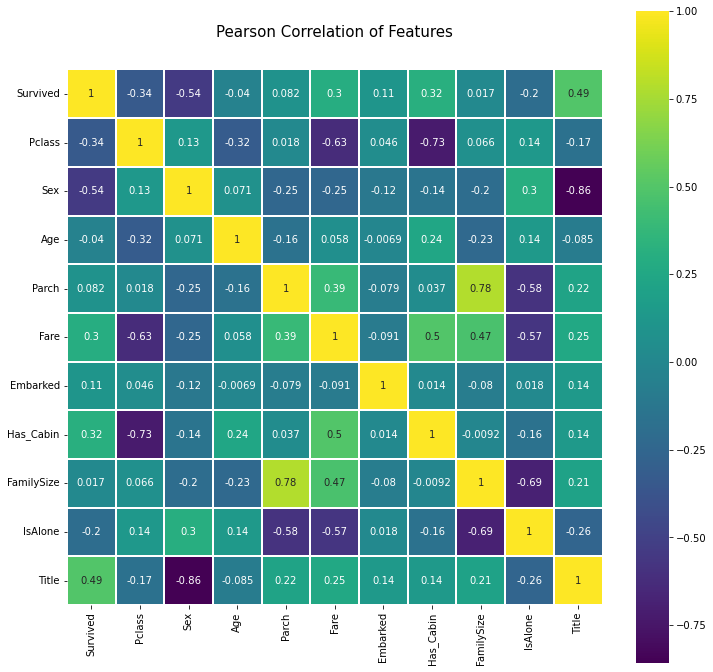

In [32]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

**Które cechy są najbardziej skorelowane z etykietą przeżycia?** <br>
Najbardziej skorelowane z etykietą przeżycia są cechy: płeć oraz tytuł.

In [33]:
corr_matrix = train.corr().abs()
features_correlation = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().sort_values(ascending=False)
for features, correlation in features_correlation.items():
    if abs(correlation) < 0.3: break
    print(features, correlation) if 'Survived' in features else None

('Survived', 'Sex') 0.543351380657755
('Survived', 'Title') 0.49203093089637107
('Survived', 'Pclass') 0.33848103596101514
('Survived', 'Has_Cabin') 0.3169115231122961


**Które cechy są najbardziej skorelowane ze sobą?** <br>
Najbardziej skorelowane są ze sobą cechy płeć oraz tytuł a także Parch oraz FamilySize.

In [34]:
for features, correlation in features_correlation.items():
    if abs(correlation) < 0.7: break
    print(features, correlation)

('Sex', 'Title') 0.8590841885754454
('Parch', 'FamilySize') 0.7831107750000581
('Pclass', 'Has_Cabin') 0.725541241828957


#### Zadanie 3. Wyznacz współczynnik przeżywalności dla każdego z pięciu różnych tytułów

In [35]:
train[train['Title']==1].head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
4,0,3,1,2,0,1,0,0,1,1,1
5,0,3,1,1,0,1,2,0,1,1,1


Klasa Rare objemuje tytuły takie jak: Lady, Capt, Col, Don, Dr, Major, Sir

In [45]:
titles_categorical = {1:'Mr', 2:'Master', 3:'Mrs', 4:'Miss', 5:'Rare'}
train.loc[:, ['Title', 'Survived']].replace({'Title': titles_categorical}).groupby('Title').mean()

# Alternatywnie:
# a = train.loc[:, ['Title', 'Survived']].replace({'Title': titles_categorical}).groupby('Title').sum()
# b = train.loc[:, ['Title', 'Survived']].replace({'Title': titles_categorical}).groupby('Title').count()
# a : b

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


#### Zadanie 4. Korzystajac ze zbioru treningowego oraz walidacji krzyzowej (10-fold) wyznacz najlepsza głebokosc drzewa decyzyjnego (kryterium podziału gini, albo entropy)

In [46]:
x_train = train.loc[:, train.columns!='Survived']
y_train = train.loc[:, 'Survived']

In [60]:
def run_cross_validation_on_trees(X, y, tree_depths, criterion, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []

    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))

    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)

    return cv_scores_mean, cv_scores_std, accuracy_scores

Dla kryterium 'entropy', optymalna głębokość drzewa wynosi 3

In [70]:
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = \
    run_cross_validation_on_trees(x_train, y_train, range(1, 25), 'entropy')

sm_cv_scores_mean_entropy = sm_cv_scores_mean
sm_cv_scores_mean_entropy.argmax() + 1

3

Dla kryterium 'gini', optymalna głębokość drzewa wynosi 3

In [69]:
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = \
    run_cross_validation_on_trees(x_train, y_train, range(1, 25), 'gini')

sm_cv_scores_mean_gini = sm_cv_scores_mean
sm_cv_scores_mean_gini.argmax() + 1

3

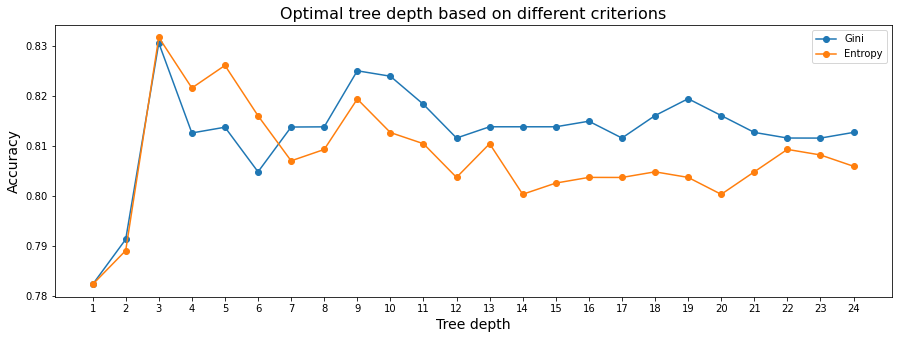

In [88]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.set_title('Optimal tree depth based on different criterions', fontsize=16)
ax.set_xlabel('Tree depth', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

# Rozdzielczość osi X
ax.set_xticks(range(1, 25))

plt.plot(range(1, 25), sm_cv_scores_mean_gini, '-o', label='Gini')
plt.plot(range(1, 25), sm_cv_scores_mean_entropy, '-o', label='Entropy')
ax.legend()

Zgodnie z uzyskanymi wynikami dla obu kryteriów podziału, optymalna głębokość drzewa wynosi 3.

#### Zadanie 5. Zbuduj drzewo decyzyjne wykorzystujac z wyznaczonej wczesniej maksymalnej głębokości

In [89]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier(max_depth = 3, criterion='entropy')
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

#### Zadanie 6. Dokonaj predykcji mozliwosci przezycia dla pasazerów ze zbioru testowego i zapisz wyniki w pliku

In [113]:
prediction = decision_tree.predict(test)
np.savetxt('decision-tree-prediction.txt', prediction, '%0.0f')
prediction

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

#### Zadanie 7. Zwizualizuj drzewo decyzyjne

In [119]:
from sklearn.tree import plot_tree

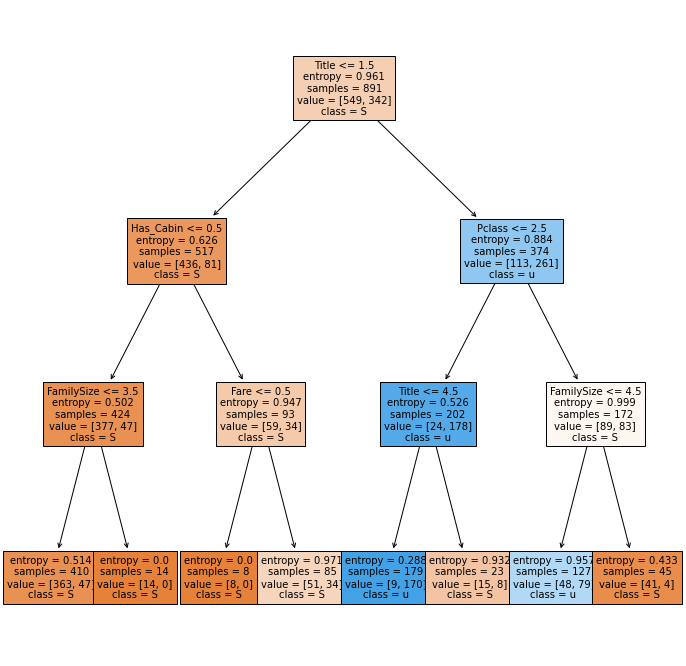

In [116]:
plt.figure(figsize=(12,12))
plot_tree(decision_tree, filled=True, feature_names=x_train.columns, class_names='Supervised', fontsize=10)
plt.show()

In [120]:
text_representation = tree.export_text(decision_tree)
print(text_representation)

|--- feature_9 <= 1.50
|   |--- feature_6 <= 0.50
|   |   |--- feature_7 <= 3.50
|   |   |   |--- class: 0
|   |   |--- feature_7 >  3.50
|   |   |   |--- class: 0
|   |--- feature_6 >  0.50
|   |   |--- feature_4 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_4 >  0.50
|   |   |   |--- class: 0
|--- feature_9 >  1.50
|   |--- feature_0 <= 2.50
|   |   |--- feature_9 <= 4.50
|   |   |   |--- class: 1
|   |   |--- feature_9 >  4.50
|   |   |   |--- class: 0
|   |--- feature_0 >  2.50
|   |   |--- feature_7 <= 4.50
|   |   |   |--- class: 1
|   |   |--- feature_7 >  4.50
|   |   |   |--- class: 0



#### Zadanie 8. Sprawdz jak na dokładnosc klasyfikacji wpływaja nastepujace parametery drzewa: kryterium podziału (gini vs. entropy), najmniejsza liczba rekordów w lisciu oraz maksymalna głebokosc drzewa

In [132]:
for min_sample_leaf in range(1, 5):
    print('\n')
    print(f'Simulation for min_sample_leaf: {min_sample_leaf}')
    for max_depth in range(1, 10):
        tree_model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_sample_leaf, criterion='entropy')
        cv_scores = cross_val_score(tree_model, x_train, y_train, cv=10, scoring='accuracy')
        print(f"\t Max depth: {max_depth} \t CV mean score: {cv_scores.mean()}")



Simulation for min_sample_leaf: 1
	 Max depth: 1 	 CV mean score: 0.7822846441947565
	 Max depth: 2 	 CV mean score: 0.7890511860174781
	 Max depth: 3 	 CV mean score: 0.8316479400749064
	 Max depth: 4 	 CV mean score: 0.8215355805243446
	 Max depth: 5 	 CV mean score: 0.8282896379525593
	 Max depth: 6 	 CV mean score: 0.813732833957553
	 Max depth: 7 	 CV mean score: 0.8114731585518102
	 Max depth: 8 	 CV mean score: 0.812621722846442
	 Max depth: 9 	 CV mean score: 0.8170786516853932


Simulation for min_sample_leaf: 2
	 Max depth: 1 	 CV mean score: 0.7822846441947565
	 Max depth: 2 	 CV mean score: 0.7890511860174781
	 Max depth: 3 	 CV mean score: 0.8316479400749064
	 Max depth: 4 	 CV mean score: 0.8215355805243446
	 Max depth: 5 	 CV mean score: 0.8260424469413234
	 Max depth: 6 	 CV mean score: 0.8193508114856429
	 Max depth: 7 	 CV mean score: 0.8238327091136078
	 Max depth: 8 	 CV mean score: 0.8182397003745319
	 Max depth: 9 	 CV mean score: 0.8283270911360798


Simulation

Maksymalna glębokość drzewa wpływa na dokładność modelu, ponieważ określą liczbę poziomów na którym będą odbywały się procesy decyzyjne. Od pewnej głębokości drzewa, dokładność modelu zaczyna spadać ze względu na dokonywanie zbyt szczegółowych podziałów - overfitting. <br>
Min Sample leaf określa minimalną liczbę próbek, dla której będzie przebiegal proces decyzyjny w ramach jednego liścia. Wpływa ona na dokładność modelu ale w mniejszym stopniu niż maksymalna głębokość drzewa. <br>
Z jednej strony kryterium giniego jest znacznie szybsze, ponieważ jest mniej kosztowne obliczeniowo, natomiast zastosowanie kryterium entropii pozwala uzyskać nieco lepsze wyniki, dla małych wartości pozostałych parametrów, co zostało przeanalizowane w ramach wykonywanego laboratorium.

#### Zadanie 9. Podziel zbiór treningowy (dla którego mamy dostepne etykiety) na nowy zbiór treningowy (75%) i nowy zbiór testowy (25%)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [136]:
decision_tree_on_original_train_data = tree.DecisionTreeClassifier(max_depth = 3, criterion='entropy')
decision_tree_on_original_train_data.fit(X_train, y_train)
y_predicted = decision_tree_on_original_train_data.predict(X_test)

#### Zadanie 10. Wyznacz i dokonaj wizualizacji macierzy rozbieznosci confusion matrix

In [137]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [138]:
confusion_matrix(y_test, y_predicted)

array([[119,  15],
       [ 23,  66]], dtype=int64)

C:\Users\msmen\anaconda3\envs\NeuralNetworksAndDeepLearning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


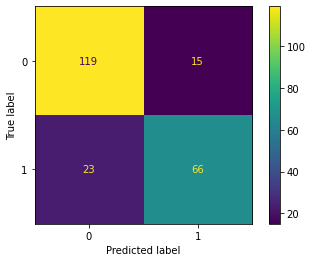

In [139]:
plot_confusion_matrix(decision_tree_on_original_train_data, X_test, y_test)

In [143]:
# 119 True Positive  - 119 osób nie przeżyło i model zaklasyfikował je poprawnie.
# 23 False Negative  - 23 osoby przeżyły ale model zaklasyfikował je te, które zginęły.
# 15 False Positive  - 15 osób nie przeżyło ale model zaklasyfikował je jako te, które przeżyły.
# 66 True Negative   - 66 osób nie przeżyło i model zaklasyfikował je poprawnie. 

#### Zadanie 11. Wyznacz miary jakości zbudowanego klasyfikatora

In [148]:
from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy Score: {accuracy_score(y_test, y_predicted)} \n")
print(classification_report(y_test, y_predicted))

Accuracy Score: 0.8295964125560538 

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       134
           1       0.81      0.74      0.78        89

    accuracy                           0.83       223
   macro avg       0.83      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223



# 2 - Klasyfikator *k-NN*

In [154]:
from sklearn.datasets import load_iris
iris = load_iris()
X_iris, y_iris = load_iris(return_X_y=True)

In [162]:
y_iris

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [150]:
df_nyt = pd.read_csv('./nyt-frame.csv', header=0)
data_nyt = df_nyt.iloc[:, 9:]
array_nyt = data_nyt.values
classes = tuple(set(df_nyt.values[:, 1]))
header = list(df_nyt.columns.values[9:])

In [161]:
from sklearn.decomposition import PCA
pca_nyt = PCA(n_components=10)
X_nyt = pca_nyt.fit_transform(array_nyt)
y_nyt = np.array(df_nyt['class.labels'])

In [163]:
y_nyt

array(['art', 'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art',
       'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art',
       'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art',
       'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art',
       'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art',
       'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art', 'art',
       'art', 'art', 'art', 'music', 'music', 'music', 'music', 'music',
       'music', 'music', 'music', 'music', 'music', 'music', 'music',
       'music', 'music', 'music', 'music', 'music', 'music', 'music',
       'music', 'music', 'music', 'music', 'music', 'music', 'music',
       'music', 'music', 'music', 'music', 'music', 'music', 'music',
       'music', 'music', 'music', 'music', 'music', 'music', 'music',
       'music', 'music', 'music', 'music', 'music'], dtype=object)

#### KNN

In [172]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from pprint import pprint
k_values = [1, 3, 5, 7]

#### Przetestowanie działania KNN na zbiorze Iris

In [203]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = \
    train_test_split(X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris)

In [204]:
for k in k_values:
    print(f'\n KNN model for {k} neighbours - IRIS DATASET')
    for metric in ['euclidean', 'manhattan']:
        print(f'\t Metric = {metric}')
        for weights in ['uniform', 'distance']:
            knn_iris = KNN(n_neighbors = k, metric = metric, weights = weights)
            accuracy = cross_val_score(knn_iris, X_train_iris, y_train_iris, cv=10).mean()
            print(f'\t\t weights = {weights}, accuracy = {accuracy}')


 KNN model for 1 neighbours - IRIS DATASET
	 Metric = euclidean
		 weights = uniform, accuracy = 0.9618181818181819
		 weights = distance, accuracy = 0.9618181818181819
	 Metric = manhattan
		 weights = uniform, accuracy = 0.9518181818181818
		 weights = distance, accuracy = 0.9518181818181818

 KNN model for 3 neighbours - IRIS DATASET
	 Metric = euclidean
		 weights = uniform, accuracy = 0.9618181818181819
		 weights = distance, accuracy = 0.9618181818181819
	 Metric = manhattan
		 weights = uniform, accuracy = 0.9618181818181819
		 weights = distance, accuracy = 0.9618181818181819

 KNN model for 5 neighbours - IRIS DATASET
	 Metric = euclidean
		 weights = uniform, accuracy = 0.9527272727272728
		 weights = distance, accuracy = 0.9618181818181819
	 Metric = manhattan
		 weights = uniform, accuracy = 0.9618181818181819
		 weights = distance, accuracy = 0.9618181818181819

 KNN model for 7 neighbours - IRIS DATASET
	 Metric = euclidean
		 weights = uniform, accuracy = 0.960909090909

#### Przetestowanie działania KNN na zbiorze NYT

In [201]:
X_train_nyt, X_test_nyt, y_train_nyt, y_test_nyt = \
    train_test_split(X_nyt, y_nyt, test_size=0.3, random_state=42, stratify=y_nyt)

In [205]:
for k in k_values:
    print(f'\n KNN model for {k} neighbours - NYT DATASET')
    for metric in ['euclidean', 'manhattan']:
        print(f'\t Metric = {metric}')
        for weights in ['uniform', 'distance']:
            knn_nyt = KNN(n_neighbors = k, metric = metric, weights = weights)
            accuracy = cross_val_score(knn_nyt, X_train_nyt, y_train_nyt, cv=10).mean()
            print(f'\t\t weights = {weights}, accuracy = {accuracy}')


 KNN model for 1 neighbours - NYT DATASET
	 Metric = euclidean
		 weights = uniform, accuracy = 0.8589285714285714
		 weights = distance, accuracy = 0.8589285714285714
	 Metric = manhattan
		 weights = uniform, accuracy = 0.8464285714285713
		 weights = distance, accuracy = 0.8464285714285713

 KNN model for 3 neighbours - NYT DATASET
	 Metric = euclidean
		 weights = uniform, accuracy = 0.8732142857142856
		 weights = distance, accuracy = 0.8732142857142856
	 Metric = manhattan
		 weights = uniform, accuracy = 0.8446428571428571
		 weights = distance, accuracy = 0.8446428571428571

 KNN model for 5 neighbours - NYT DATASET
	 Metric = euclidean
		 weights = uniform, accuracy = 0.8857142857142856
		 weights = distance, accuracy = 0.8714285714285713
	 Metric = manhattan
		 weights = uniform, accuracy = 0.8303571428571429
		 weights = distance, accuracy = 0.8160714285714284

 KNN model for 7 neighbours - NYT DATASET
	 Metric = euclidean
		 weights = uniform, accuracy = 0.8857142857142856

k-fold cross-validation - uczymy model w kilku iteracjach, a następnie uśredniamy wyniki. W każdej iteracji zmieniamy zbiór który jest naszym zbiorem testowych oraz zbiór który jest zbiorem treningowym. Dzięki temu możemy znaleźć "optymalne" parametry modelu w sposób iteracyjny.
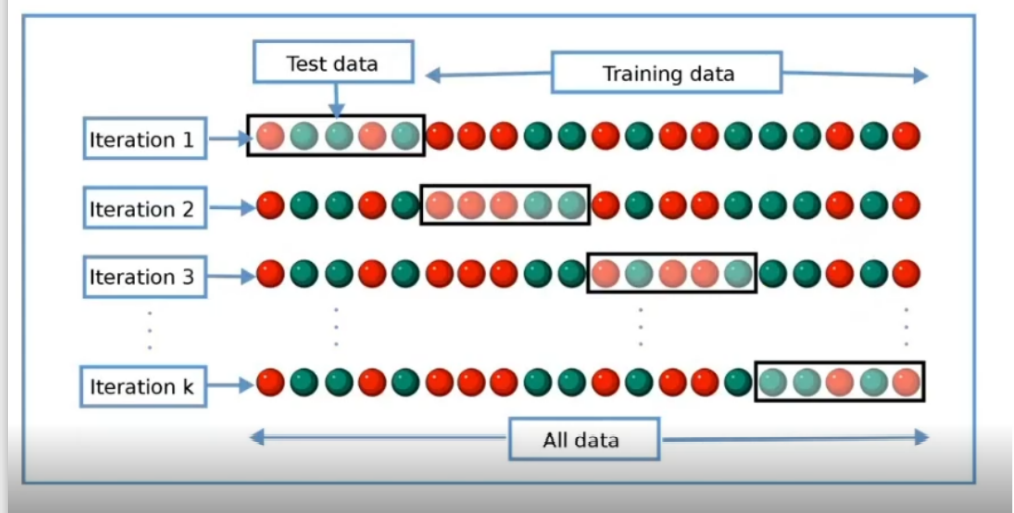

Wprowadzenie wag odległości oraz innej miary odległości ma wplyw na dokładność modelu. Dla zbioru NYC, zastosowanie metryki euklidesowej przynosi lepsze rezultaty jeśli chodzi o dokladność modelu. Dla zbioru irysów, można zaobserwować nieznaczne różnice pomiędzy metrykami. Intuicja stojąca za wykorzystaniem wag w KNN polega na tym, aby nadać większą wagę punktom, które są blisko, a mniejszą wagę dalszym. 